<a href="https://colab.research.google.com/github/Miihi77/Basic-Machine-Learning/blob/main/Basic_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import os
import os.path
from os import path

import cv2
import PIL
import PIL.Image
from PIL import Image

import pathlib
from pathlib import Path
import imghdr
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
# Code for linking Google drive to Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Option 1: Unzipping file in for google drive

!unzip 'drive/MyDrive/(Image Data-Group-MinMax) 4.1 Group Activity_ Collecting and Preparing Image Data.zip'

Archive:  drive/MyDrive/(Image Data-Group-MinMax) 4.1 Group Activity_ Collecting and Preparing Image Data.zip
   creating: content/images/
   creating: content/images/whiteCurrant_images/
  inflating: content/images/whiteCurrant_images/000080.png  
  inflating: content/images/whiteCurrant_images/000020.jpg  
  inflating: content/images/whiteCurrant_images/000092.jpg  
  inflating: content/images/whiteCurrant_images/000087.jpg  
  inflating: content/images/whiteCurrant_images/000002.jpg  
  inflating: content/images/whiteCurrant_images/000009.jpg  
  inflating: content/images/whiteCurrant_images/000001.png  
  inflating: content/images/whiteCurrant_images/000037.jpg  
  inflating: content/images/whiteCurrant_images/000041.jpg  
  inflating: content/images/whiteCurrant_images/000082.jpg  
  inflating: content/images/whiteCurrant_images/000004.jpg  
  inflating: content/images/whiteCurrant_images/000025.jpg  
  inflating: content/images/whiteCurrant_images/000054.jpg  
  inflating: conten

In [ ]:
# Option 2: Using upload to directly upload the file

from google.colab import files
uploaded = files.upload()
uploaded_filename = list(uploaded.keys())[0]
!unzip '/content/{uploaded_filename}'

In [7]:
# Validate the images to be used
data_dir = '/content/images/'
os.mkdir('/content/invalid_images')

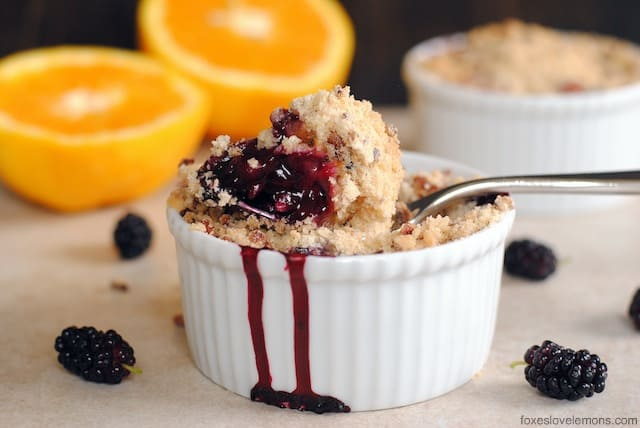

In [9]:
# For Opening Images within the File
Image.open('content/images/mulberries_images/000023.jpg')

In [18]:
# Preprocessing Section

def check_images(s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:
                f_path=os.path.join (klass_path,f)
                index=f.rfind('.')
                ext=f[index+1:].lower()
                if ext not in ext_list:
                    print('file ', f_path, ' has an invalid extension ', ext)
                    bad_ext.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

# Change the folder path below to the folder of your data that you have uploaded
source_dir =r'/content/images/'
# This is a test code to check if any files that you have downloaded have incorrect extensions
# The allowed extensions are listed below
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp']
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  redCurrant_images
processing class directory  mulberries_images
processing class directory  whiteCurrant_images
processing class directory  raspberry_images
 no improper image files were found


In [13]:
# Change the folder path below to the folder of your data that you have uploaded
source_dir = "/content/images/"
# Change the folder name below to the folder for invalid images that you created earlier
destination_folder_path = '/content/invalid_images'
# The image extensions below should list all the file extensions that are being used in your dataset
image_extensions = [".png", ".jpg", '.bmp', '.jpeg']
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(source_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        destination_file_path = os.path.join(destination_folder_path, os.path.basename(filepath))
        if img_type is None:
            print(f"{filepath} is not an image")
            shutil.move(filepath, destination_file_path)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            shutil.move(filepath, destination_file_path)

# Splitting the Dataset
Code for splitting the dataset

In [15]:
#Demo Value
batch_size = 32
img_height = 180
img_width = 180

In [19]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  # Change the value below on both the training and validation datasets
  # Take note that they should have the same value
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 4 classes.
Using 320 files for training.


In [20]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  # Change the value below on both the training and validation datasets
  # Take note that they should have the same value
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 4 classes.
Using 80 files for validation.


In [21]:
class_names = train_ds.class_names
print(class_names)

['mulberries_images', 'raspberry_images', 'redCurrant_images', 'whiteCurrant_images']


In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# This should print out a range of values that resembles [0, 1]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [26]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  # You can try adjusting the activation function being utilized here for our model
  # You can have the same activation function for all layers of the model
  # You can also try using different activation functions for each layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,156 (15.22 MB)

 Trainable params: 3,989,156 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
epochs = 15 # Try changing the epoch value listed here to increase your training time
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
 8/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2812 - loss: 1.3669

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 958ms/step - accuracy: 0.2851 - loss: 1.3664 - val_accuracy: 0.2917 - val_loss: 1.3604
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4457 - loss: 1.2950 - val_accuracy: 0.4583 - val_loss: 1.2106
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 812ms/step - accuracy: 0.5626 - loss: 1.1295 - val_accuracy: 0.2708 - val_loss: 1.1906
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6021 - loss: 0.9848 - val_accuracy: 0.6875 - val_loss: 0.8135
Epoch 5/15
 8/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6943 - loss: 0.8347

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6938 - loss: 0.8254 - val_accuracy: 0.6458 - val_loss: 0.7894
Epoch 6/15
 8/10 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step - accuracy: 0.7974 - loss: 0.6222

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 825ms/step - accuracy: 0.7949 - loss: 0.6266 - val_accuracy: 0.6875 - val_loss: 0.7901
Epoch 7/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


 8/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7911 - loss: 0.5614

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7938 - loss: 0.5606 - val_accuracy: 0.6875 - val_loss: 0.7106
Epoch 8/15
 8/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8859 - loss: 0.4021

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8900 - loss: 0.4008 - val_accuracy: 0.7292 - val_loss: 0.8119
Epoch 9/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


 8/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8965 - loss: 0.3448

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 977ms/step - accuracy: 0.9001 - loss: 0.3388 - val_accuracy: 0.7708 - val_loss: 0.6718
Epoch 10/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


 8/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9641 - loss: 0.2325

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9627 - loss: 0.2315 - val_accuracy: 0.7500 - val_loss: 0.8666
Epoch 11/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


 8/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9598 - loss: 0.1524

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 853ms/step - accuracy: 0.9608 - loss: 0.1495 - val_accuracy: 0.7292 - val_loss: 0.8447
Epoch 12/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


 8/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9753 - loss: 0.1019

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 935ms/step - accuracy: 0.9740 - loss: 0.1023 - val_accuracy: 0.7292 - val_loss: 0.8406
Epoch 13/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


 8/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9729 - loss: 0.0905

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9736 - loss: 0.0908 - val_accuracy: 0.6875 - val_loss: 0.9178
Epoch 14/15
 8/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9926 - loss: 0.0630

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 834ms/step - accuracy: 0.9909 - loss: 0.0682 - val_accuracy: 0.7083 - val_loss: 1.0847
Epoch 15/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


 8/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9884 - loss: 0.0610

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 855ms/step - accuracy: 0.9868 - loss: 0.0642 - val_accuracy: 0.7083 - val_loss: 1.4126


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


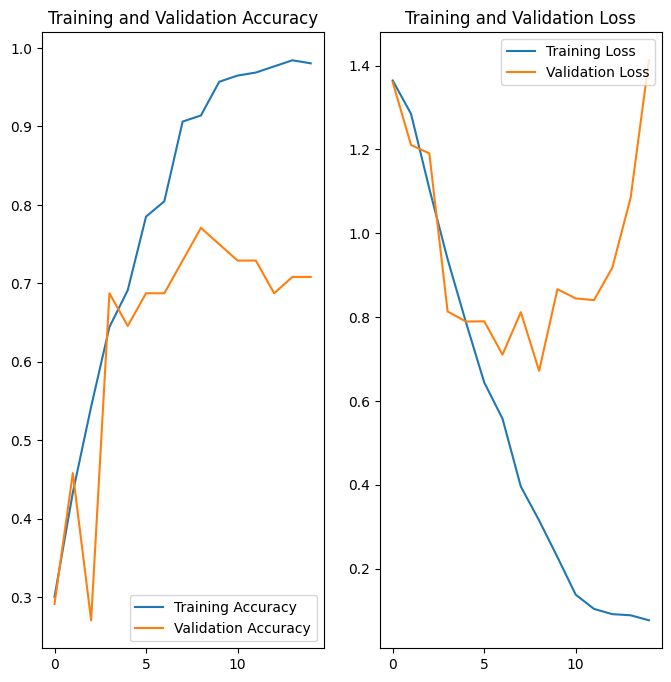

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.10), # Try adjusting this value to get different results (Range: 0 to 1)
    layers.RandomZoom(0.15), # Try adjusting this value to get different results (Range: 0 to 1)
    layers.RandomContrast(0.05), # Try adjusting this value to get different results (Range: 0 to 1)
  ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


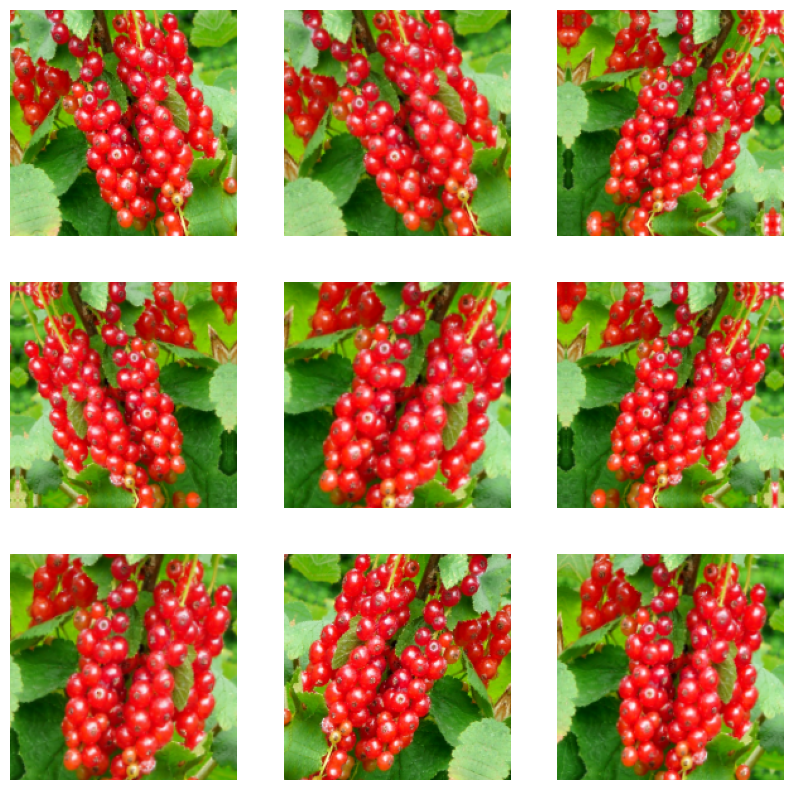

In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [35]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  # You can try adjusting the activation function being utilized here for our model
  # You can have the same activation function for all layers of the model
  # You can also try using different activation functions for each layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [36]:
# Restraining the Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,156 (15.22 MB)

 Trainable params: 3,989,156 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
epochs = 10 # Try changing the epoch value listed here to increase your training time
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
 8/10 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6859 - loss: 0.7888

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6886 - loss: 0.7824 - val_accuracy: 0.6250 - val_loss: 1.1068
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


 8/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6749 - loss: 0.8055

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6751 - loss: 0.7998 - val_accuracy: 0.7083 - val_loss: 0.8229
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 999ms/step - accuracy: 0.7032 - loss: 0.7028 - val_accuracy: 0.6250 - val_loss: 1.2024
Epoch 4/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


 8/10 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6494 - loss: 0.7792

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6594 - loss: 0.7693 - val_accuracy: 0.6875 - val_loss: 0.8439
Epoch 5/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


 8/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7454 - loss: 0.6915

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7471 - loss: 0.6832 - val_accuracy: 0.6875 - val_loss: 0.9707
Epoch 6/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


 8/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7278 - loss: 0.6739

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7291 - loss: 0.6684 - val_accuracy: 0.6875 - val_loss: 0.9148
Epoch 7/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


 8/10 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7831 - loss: 0.5675

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7789 - loss: 0.5769 - val_accuracy: 0.7083 - val_loss: 0.7809
Epoch 8/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


 8/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7724 - loss: 0.5494

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7702 - loss: 0.5546 - val_accuracy: 0.6875 - val_loss: 0.9100
Epoch 9/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


 8/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7512 - loss: 0.6140

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 987ms/step - accuracy: 0.7541 - loss: 0.6093 - val_accuracy: 0.6667 - val_loss: 1.1409
Epoch 10/10
 8/10 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7706 - loss: 0.5932

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7657 - loss: 0.5957 - val_accuracy: 0.6875 - val_loss: 1.0627


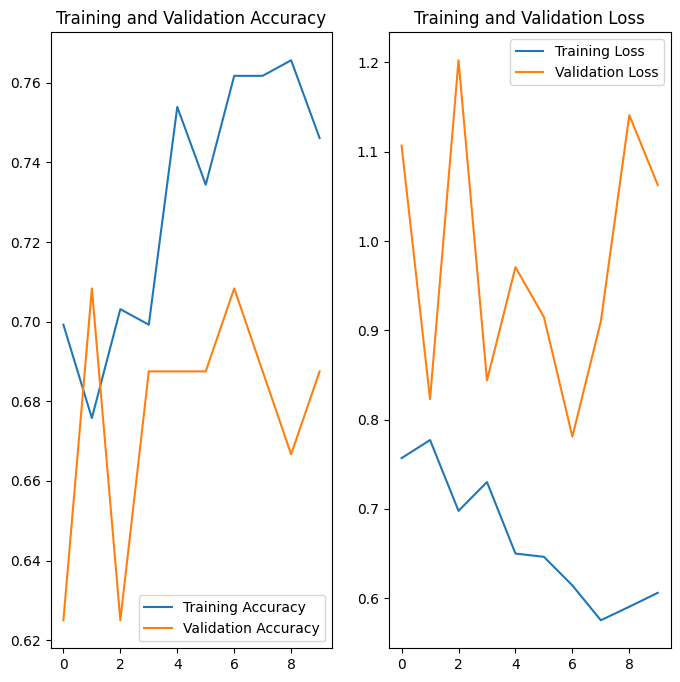

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
# Just replace the "test_image_url" with the URL of the image you would like to test
test_image_url = "https://upload.wikimedia.org/wikipedia/commons/8/86/Maltese_puppy.jpeg"
# Change the "test_image_path" data with the name of the image that you will be testing against the model
test_image_path = tf.keras.utils.get_file('Maltese_puppy', origin=test_image_url)

img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1591898/1591898 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
This image most likely belongs to whiteCurrant_images with a 48.56 percent confidence.
